In [1]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [7]:
df_list_pickle_file = '/home/users/yuzhuang/yuzhuang_scratch/tiam/tiam_rbfe/executions/rep1/simulations/transformations/WT~1A0F/fe/Results/x_df_list.pickle'
#df_list_pickle_file = '/oak/stanford/groups/rondror/users/yuzhuang/software/batter_dev/examples/ABFE_simulations_test/executions/rep5/simulations/CAU/fe/Results/z_df_list.pickle'
df_list = pickle.load(open(df_list_pickle_file, 'rb'))

In [8]:
# get reduced form
df_list = [df.subtract(df.iloc[:, idf], axis=0) for idf, df in enumerate(df_list)]

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def plot_du_distributions_from_dfs(
    dfs,
    native_lams,              # same length as dfs; native λ for each df
    lam_max=1,
    neighbor_step=1,
    burn_in=0.0,              # fraction
    bins=80,
    clip_percentiles=(0.5, 99.5),
    density=True,
    alpha=1,
    figsize=(10, 6),
    lam_tol=1e-6,
):
    if len(dfs) != len(native_lams):
        raise ValueError("dfs and native_lams must have the same length.")

    du_by_key = {}

    for df, lam_meta in zip(dfs, native_lams):
        df = df.copy()

        # burn-in
        if burn_in:
            n0 = int(len(df) * float(burn_in))
            df = df.iloc[n0:, :]
        if len(df) == 0:
            continue

        # ensure float lambda columns
        df.columns = [float(c) for c in df.columns]
        cols = np.array(df.columns, dtype=float)

        # snap provided native λ to nearest column
        lam_meta = float(lam_meta)
        i = int(np.argmin(np.abs(cols - lam_meta)))
        lam_i = float(cols[i])

        if abs(lam_i - lam_meta) > lam_tol:
            # not fatal, but warns you your provided λ doesn't match columns
            # print(f"Warning: native λ {lam_meta} snapped to {lam_i}")
            pass

        if lam_i > lam_max:
            continue

        j = i + neighbor_step
        if j >= len(cols):
            continue
        lam_j = float(cols[j])

        du = df.iloc[:, j].to_numpy(float) - df.iloc[:, i].to_numpy(float)
        key = f"{lam_i:g}→{lam_j:g}"
        du_by_key.setdefault(key, []).append(du)

    du_by_key = {k: np.concatenate(v) for k, v in du_by_key.items()}
    if not du_by_key:
        raise ValueError("No usable windows found.")

    all_du = np.concatenate(list(du_by_key.values()))
    all_du = all_du[np.isfinite(all_du)]
    lo, hi = np.percentile(all_du, clip_percentiles)
    edges = np.linspace(lo, hi, bins + 1)

    plt.figure(figsize=figsize)
    for key in sorted(du_by_key, key=lambda k: float(k.split("→")[0])):
        du = du_by_key[key]
        du = du[np.isfinite(du)]
        du = du[(du >= lo) & (du <= hi)]
        if len(du) < 10:
            continue
        hist, _ = np.histogram(du, bins=edges, density=density)
        centers = 0.5 * (edges[:-1] + edges[1:])
        plt.plot(centers, hist, alpha=alpha, label=key)

    plt.xlabel("ΔU = U(λ_next) − U(λ_native)")
    plt.ylabel("Probability density" if density else "Counts")
    plt.title(f"Perturbation energy distributions for λ ∈ [0, {lam_max}] (step={neighbor_step})")
    if len(du_by_key) <= 15:
        plt.legend(fontsize=8, ncol=3)
    plt.tight_layout()
    plt.show()

    return du_by_key


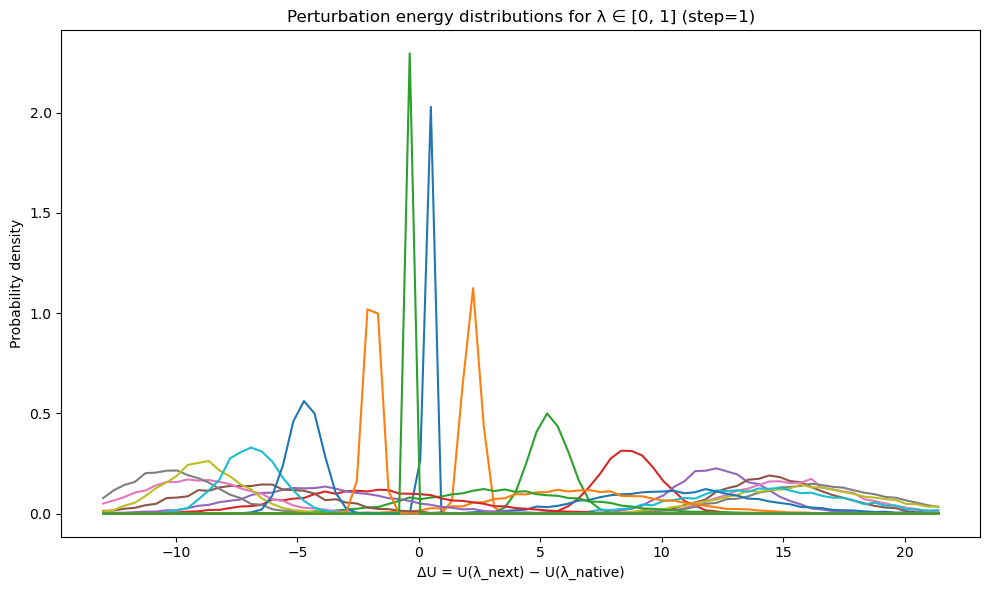

In [10]:
du_by_key = plot_du_distributions_from_dfs(df_list, native_lams=df_list[0].columns.tolist())